In [1]:
from collections import OrderedDict

import torch
from torch import nn
import torch.nn.functional as F
# import torchvision
# from torchvision import models
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign

from torchvision.models.utils import load_state_dict_from_url

from generalized_rcnn import GeneralizedRCNN
from rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from roi_heads import RoIHeads
from transform import GeneralizedRCNNTransform
from backbone_utils import resnet_fpn_backbone
from torchvision import transforms

/home/user/.local/lib/python3.5/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
__all__ = [
    "FasterRCNN", "fasterrcnn_resnet50_fpn",
]


class FasterRCNN(GeneralizedRCNN):
    """
    Implements Faster R-CNN.

    The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each
    image, and should be in 0-1 range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with values
          between 0 and H and 0 and W
        - labels (Int64Tensor[N]): the class label for each ground-truth box

    The model returns a Dict[Tensor] during training, containing the classification and regression
    losses for both the RPN and the R-CNN.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as
    follows:
        - boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with values between
          0 and H and 0 and W
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction

    Arguments:
        backbone (nn.Module): the network used to compute the features for the model.
            It should contain a out_channels attribute, which indicates the number of output
            channels that each feature map has (and it should be the same for all feature maps).
            The backbone should return a single Tensor or and OrderedDict[Tensor].
        num_classes (int): number of output classes of the model (including the background).
            If box_predictor is specified, num_classes should be None.
        min_size (int): minimum size of the image to be rescaled before feeding it to the backbone
        max_size (int): maximum size of the image to be rescaled before feeding it to the backbone
        image_mean (Tuple[float, float, float]): mean values used for input normalization.
            They are generally the mean values of the dataset on which the backbone has been trained
            on
        image_std (Tuple[float, float, float]): std values used for input normalization.
            They are generally the std values of the dataset on which the backbone has been trained on
        rpn_anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        rpn_head (nn.Module): module that computes the objectness and regression deltas from the RPN
        rpn_pre_nms_top_n_train (int): number of proposals to keep before applying NMS during training
        rpn_pre_nms_top_n_test (int): number of proposals to keep before applying NMS during testing
        rpn_post_nms_top_n_train (int): number of proposals to keep after applying NMS during training
        rpn_post_nms_top_n_test (int): number of proposals to keep after applying NMS during testing
        rpn_nms_thresh (float): NMS threshold used for postprocessing the RPN proposals
        rpn_fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training of the RPN.
        rpn_bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training of the RPN.
        rpn_batch_size_per_image (int): number of anchors that are sampled during training of the RPN
            for computing the loss
        rpn_positive_fraction (float): proportion of positive anchors in a mini-batch during training
            of the RPN
        box_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in
            the locations indicated by the bounding boxes
        box_head (nn.Module): module that takes the cropped feature maps as input
        box_predictor (nn.Module): module that takes the output of box_head and returns the
            classification logits and box regression deltas.
        box_score_thresh (float): during inference, only return proposals with a classification score
            greater than box_score_thresh
        box_nms_thresh (float): NMS threshold for the prediction head. Used during inference
        box_detections_per_img (int): maximum number of detections per image, for all classes.
        box_fg_iou_thresh (float): minimum IoU between the proposals and the GT box so that they can be
            considered as positive during training of the classification head
        box_bg_iou_thresh (float): maximum IoU between the proposals and the GT box so that they can be
            considered as negative during training of the classification head
        box_batch_size_per_image (int): number of proposals that are sampled during training of the
            classification head
        box_positive_fraction (float): proportion of positive proposals in a mini-batch during training
            of the classification head
        bbox_reg_weights (Tuple[float, float, float, float]): weights for the encoding/decoding of the
            bounding boxes

    Example::

        >>> import torch
        >>> import torchvision
        >>> from torchvision.models.detection import FasterRCNN
        >>> from torchvision.models.detection.rpn import AnchorGenerator
        >>> # load a pre-trained model for classification and return
        >>> # only the features
        >>> backbone = torchvision.models.mobilenet_v2(pretrained=True).features
        >>> # FasterRCNN needs to know the number of
        >>> # output channels in a backbone. For mobilenet_v2, it's 1280
        >>> # so we need to add it here
        >>> backbone.out_channels = 1280
        >>>
        >>> # let's make the RPN generate 5 x 3 anchors per spatial
        >>> # location, with 5 different sizes and 3 different aspect
        >>> # ratios. We have a Tuple[Tuple[int]] because each feature
        >>> # map could potentially have different sizes and
        >>> # aspect ratios
        >>> anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
        >>>                                    aspect_ratios=((0.5, 1.0, 2.0),))
        >>>
        >>> # let's define what are the feature maps that we will
        >>> # use to perform the region of interest cropping, as well as
        >>> # the size of the crop after rescaling.
        >>> # if your backbone returns a Tensor, featmap_names is expected to
        >>> # be [0]. More generally, the backbone should return an
        >>> # OrderedDict[Tensor], and in featmap_names you can choose which
        >>> # feature maps to use.
        >>> roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
        >>>                                                 output_size=7,
        >>>                                                 sampling_ratio=2)
        >>>
        >>> # put the pieces together inside a FasterRCNN model
        >>> model = FasterRCNN(backbone,
        >>>                    num_classes=2,
        >>>                    rpn_anchor_generator=anchor_generator,
        >>>                    box_roi_pool=roi_pooler)
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
    """

    def __init__(self, backbone, num_classes=None,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # RPN parameters
                 rpn_anchor_generator=None, rpn_head=None,
                 rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 # Box parameters
                 box_roi_pool=None, box_head=None, box_predictor=None,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None):
        print("RCNN")
        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)")

        assert isinstance(rpn_anchor_generator, (AnchorGenerator, type(None)))
        assert isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None)))

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor "
                                 "is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
            aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
            rpn_anchor_generator = AnchorGenerator(
                anchor_sizes, aspect_ratios
            )
        if rpn_head is None:
            rpn_head = RPNHead(
                out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
            )

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=7,
                sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(
                out_channels * resolution ** 2,
                representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(
                representation_size,
                num_classes)

        roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

        super(FasterRCNN, self).__init__(backbone, rpn, roi_heads, transform)


class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Arguments:
        in_channels (int): number of input channels
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_channels, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x


class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Arguments:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas


model_urls = {
    'fasterrcnn_resnet50_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth',
}


def fasterrcnn_resnet50_fpn(pretrained=False, progress=True,
                            num_classes=91, pretrained_backbone=True, **kwargs):
    """
    Constructs a Faster R-CNN model with a ResNet-50-FPN backbone.

    The input to the model is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each
    image, and should be in ``0-1`` range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with values
          between ``0`` and ``H`` and ``0`` and ``W``
        - labels (``Int64Tensor[N]``): the class label for each ground-truth box

    The model returns a ``Dict[Tensor]`` during training, containing the classification and regression
    losses for both the RPN and the R-CNN.
 
    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as
    follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with values between
          ``0`` and ``H`` and ``0`` and ``W``
        - labels (``Int64Tensor[N]``): the predicted labels for each image
        - scores (``Tensor[N]``): the scores or each prediction

    Example::

        >>> model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)

    Arguments:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    backbone = resnet_fpn_backbone('resnet50', pretrained_backbone)
    model = FasterRCNN(backbone, num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['fasterrcnn_resnet50_fpn_coco'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


In [3]:
# import torchvision
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

RCNN


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [4]:
from IPython.display import Video
# videopath = 'project.avi'
# Video(videopath)

In [5]:
pwd

'/home/user/Desktop/IndepedentStudy/IS_RCNN_Experiments/vision/torchvision/models/detection'

In [6]:
videopath = 'images/overpass.mp4'
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

%pylab inline 
import cv2
from IPython.display import clear_output


Populating the interactive namespace from numpy and matplotlib


In [7]:
vid = cv2.VideoCapture(videopath)
length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = vid.get(cv2.CAP_PROP_FPS)

print(length, width,height,fps)

812 1280 720 30.0


In [8]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [9]:
from PIL import Image

def get_prediction(img_path, threshold,model):
#   img = Image.open(img_path) # Load the image
  img = img_path
  transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
#   print(pred)
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred['boxes'].detach().numpy())] # Bounding boxes
  pred_ids = list(pred['tracker_id'].detach().numpy())
#   pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
#   pred_boxes = pred_boxes[:pred_t+1]
#   pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class,pred_ids

In [12]:
def object_detection_api(img_path, model,ii, threshold=0.9, rect_th=3, text_size=3, text_th=3):
 
  boxes, pred_cls, pred_ids = get_prediction(img_path, threshold, model) # Get predictions
  img = numpy.array(img_path) 
#   img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,str(pred_cls[i])+"_"+str(pred_ids[i]), boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(20,30)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
#   plt.show()
  plt.savefig("output_img/{i}.jpg".format(i=ii))
#   cv2.imwrite("output_img/"+outfile, img) 
  return img

KALMAN-FILTER FAST-RCNN replacing the RPN and ROI for 5 frames

Run features through the backbone
Run features through the proposals:
Run features through the roi:
1


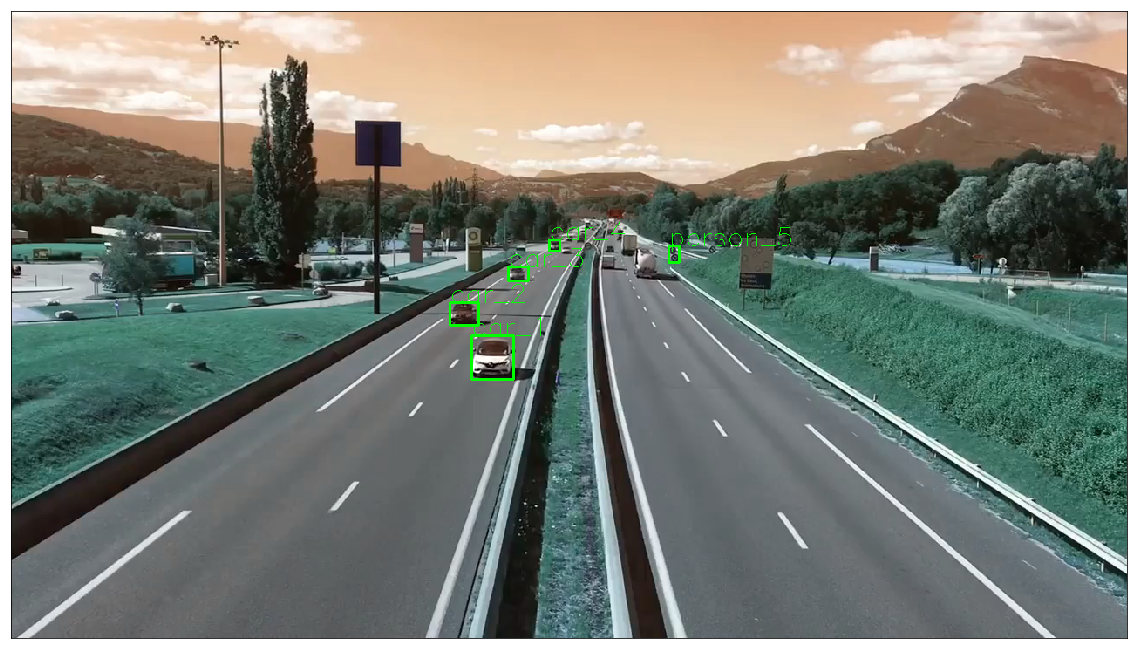

print i 0
Run features through the backbone
Run features through the proposals:
Run features through the roi:
2


/home/user/.local/lib/python3.5/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

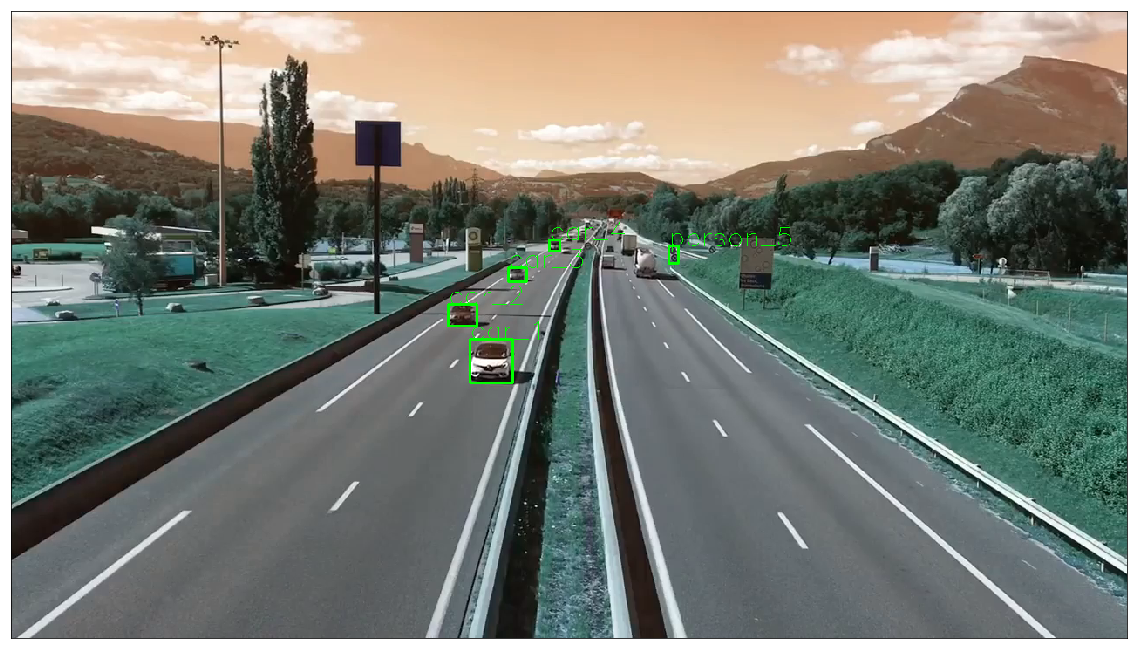

print i 1
Run features through the backbone
Run features through the proposals:
Run features through the roi:
3


/home/user/.local/lib/python3.5/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

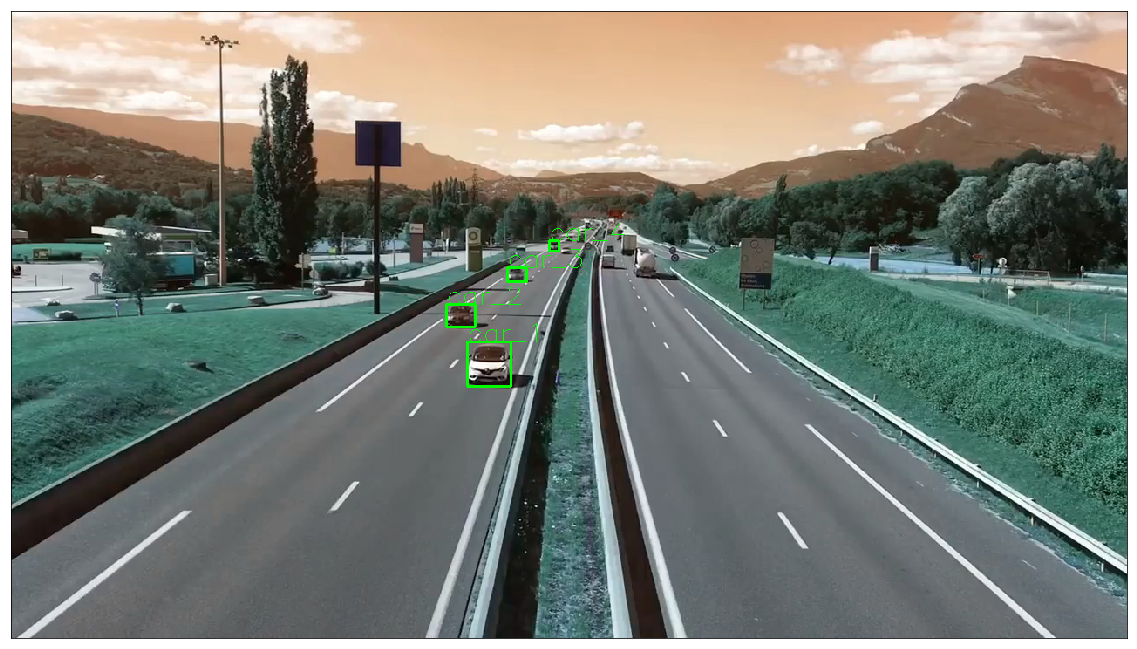

print i 2
Run features through the backbone
Run features through the proposals:
Run features through the roi:
4


/home/user/.local/lib/python3.5/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

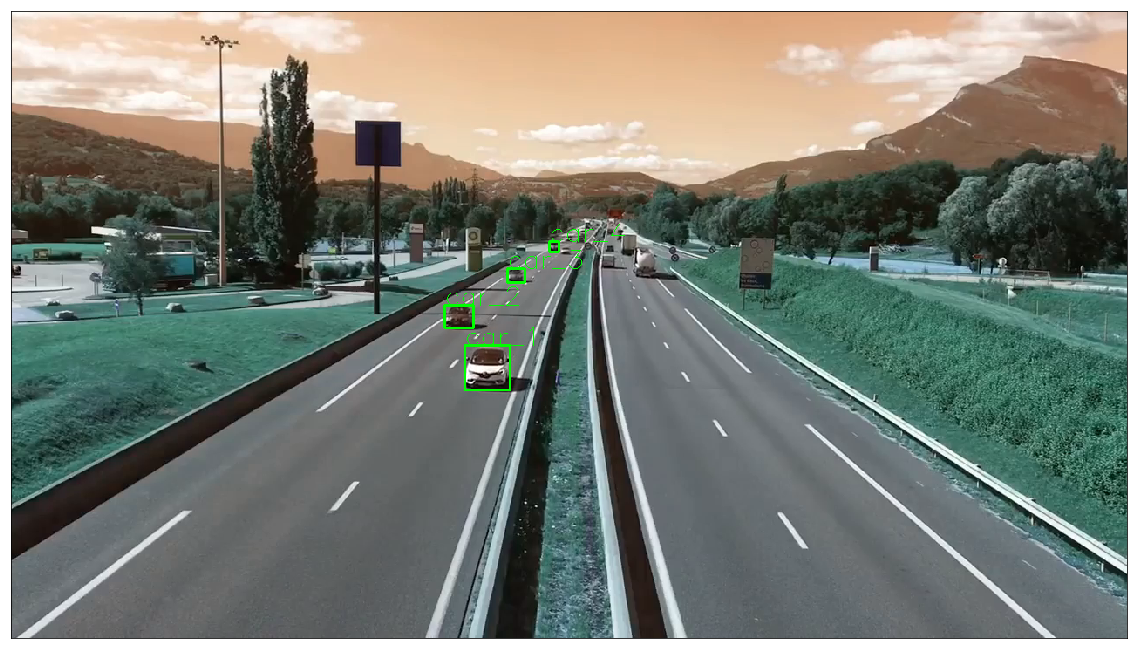

print i 3
Run features through the backbone
Run features through the proposals:
Run features through the roi:
5


/home/user/.local/lib/python3.5/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

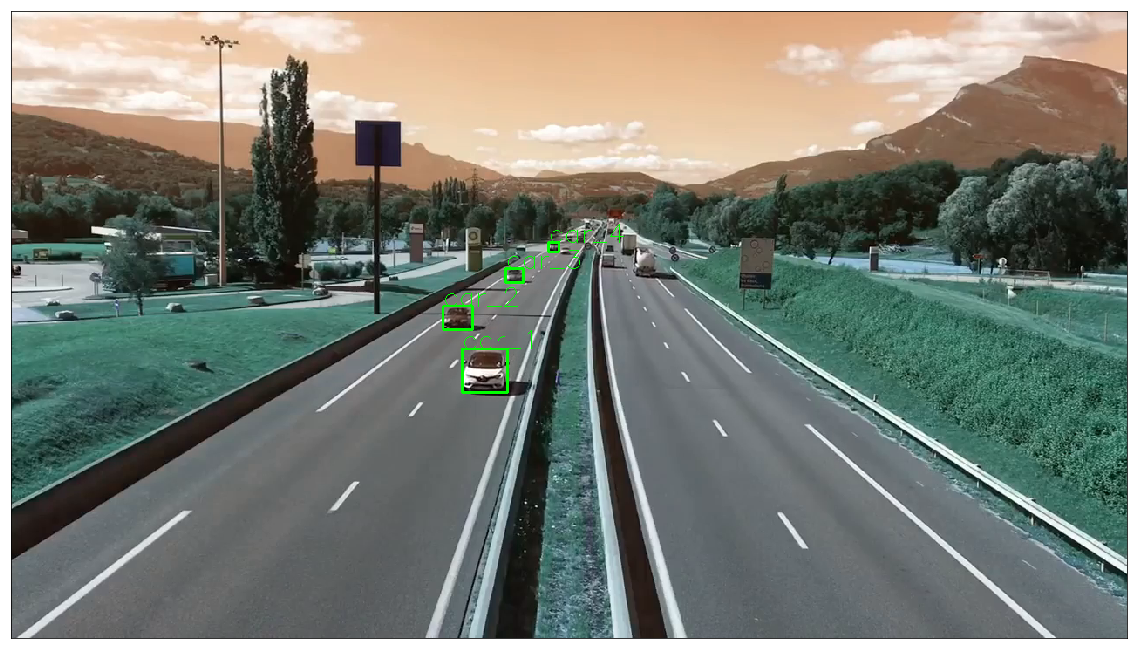

print i 4
Run features through the backbone
Run features through the proposals:
Run features through the roi:
6


/home/user/.local/lib/python3.5/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

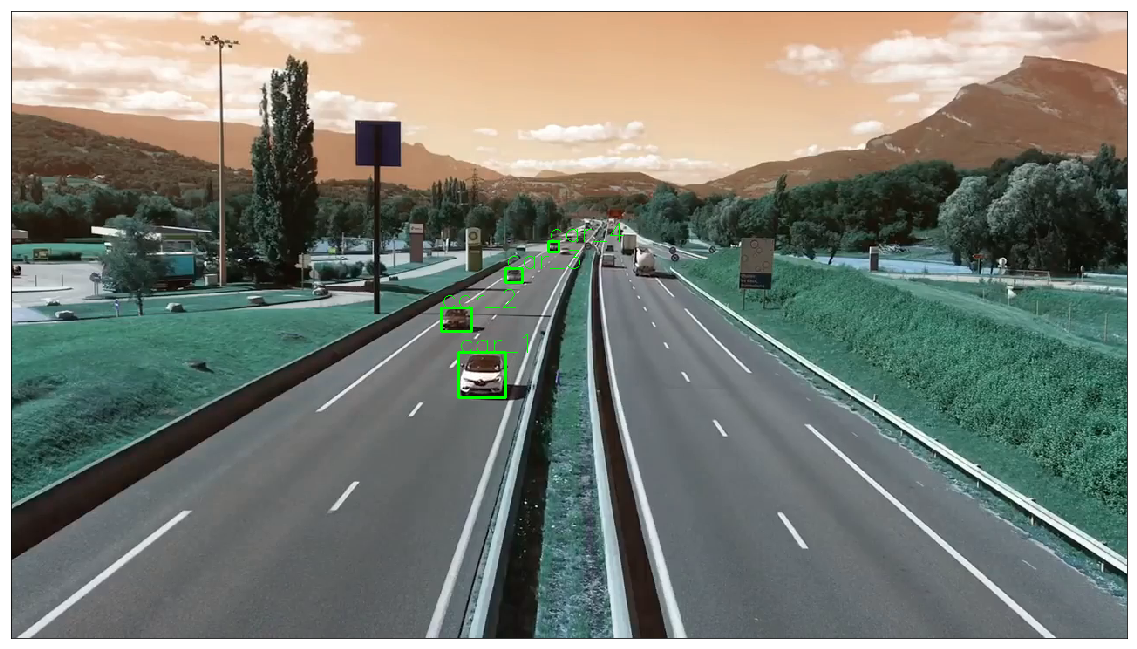

print i 5
Run features through the backbone
Run features through the proposals:
Run features through the roi:
7


/home/user/.local/lib/python3.5/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

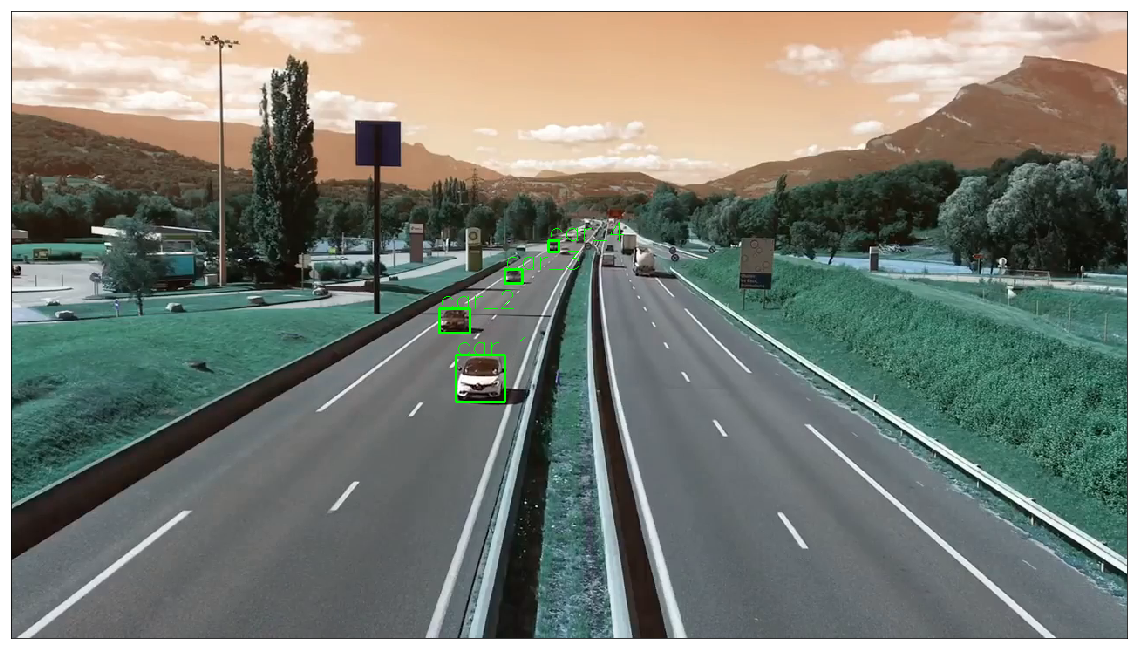

print i 6
Run features through the backbone
Run features through the proposals:
Run features through the roi:
8


/home/user/.local/lib/python3.5/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

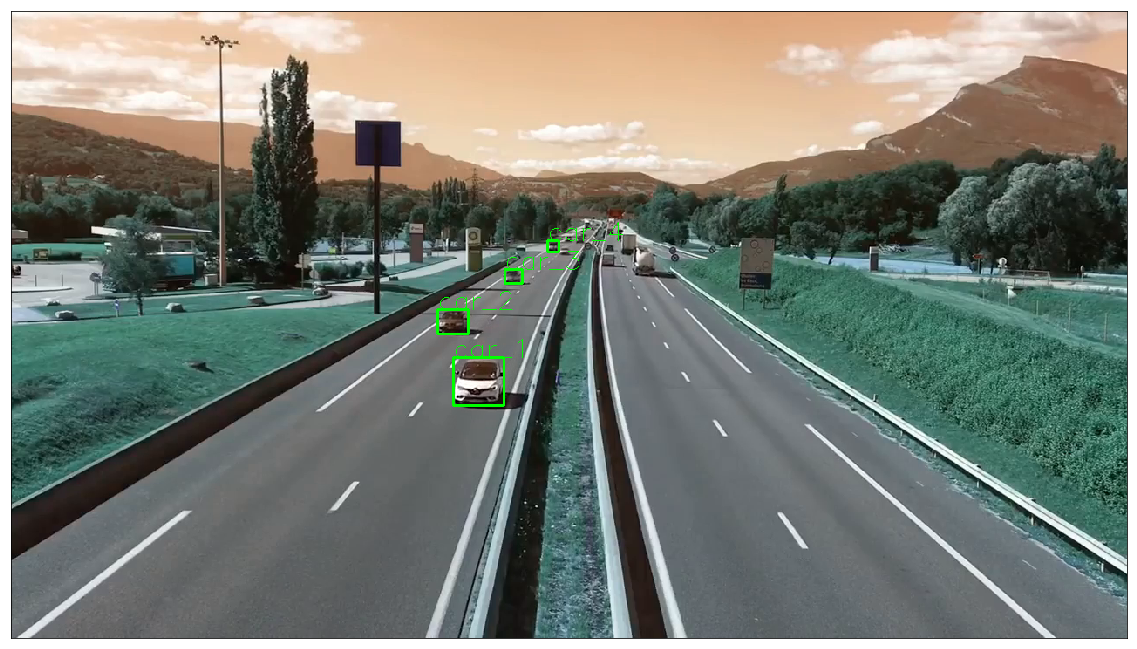

print i 7
Run features through the backbone


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [11]:
vid = cv2.VideoCapture(videopath)

# for ii in range(500):
ii = 0
while(vid.isOpened() and ii < 100 ):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
#     object_detection_api(pilimg,model,"out_"+str(ii)+".jpg", rect_th=2, text_th=1, text_size=1)
    object_detection_api(pilimg,model,ii, threshold=0.9, rect_th=2, text_th=1, text_size=1)
    ii=ii+1

In [ ]:
import imageio
import matplotlib.pyplot as plt

In [ ]:

n = 100
gif_path = "results.gif"
frames_path = "output_img/{i}.jpg"

# n = 100
# plt.figure(figsize=(4,4))
# for i, x in enumerate(range(n)):
#     plt.scatter(x/n, x/n)
#     plt.xlim(0, 1)
#     plt.ylim(0, 1)
#     plt.savefig("{i}.jpg".format(i=i))

with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(1,n):
        writer.append_data(imageio.imread(frames_path.format(i=i)))


In [ ]:
from pygifsicle import optimize

optimize(gif_path, "optimized.gif") # For creating a new one